## Phylogenetic generalized least squares model fit for quartet data

--------------------------

```
Manuscript: "Misconceptions on Missing Data in RAD-seq Phylogenetics"
Notebook author: Deren Eaton 
Contact: deren.eaton@yale.edu
Date: 8/16/2016
```

------------------------

This analysis is similar to a standard phylogenetic generalized least squares model fit in that we are trying to perform a regression on data for which there is a lot of non-independence of the data points. If we were comparing species the phylogeny would provide an estimate of the covariance structure where shared branch lengths among species represent their shared history. Here we are not comparing species as our data points but rather quartets of species. Our covariance structure is thus the length of shared branch lengths among sets of four taxa. The code below sets up a framework for doing this. Although the model is not perfect it provides a first step in the right direction and we show it performs better than when we do not account for the non-independence among quartets at all when analyzing them. Below you will find the following: 

--------------------

1. A test of pgls in R using a simulated tree and data.
2. Code for measuring a covariance matrix from quartet data.
3. Code for building a large data set of variables for our quartet regressions from pyrad outputs.
4. A test of our pgls quartet regression code on simulated RAD data.
5. Fits of our pgls quartet regression code on 10 empirical data sets. 

____________________________

### Import Python libraries

In [1]:
## import Python libraries
from scipy.optimize import fminbound
import numpy as np
import pandas as pd
import itertools
import ete3
import rpy2
import copy
import glob
import gzip
import os

### We're gonna be running R code as well, so we need the following:

The R code is run using 'rmagic' commands in IPython, so to copy this code it would be easiest if you also ran it in a Jupyter/IPython notebook. 

In [2]:
## requires rpy2
%load_ext rpy2.ipython

In [3]:
%%R

## load a few R libraries
library(ape)
library(ade4)
library(nlme)

### To run parallel Python code using ipyparallel
In a separate terminal run the command below to start N engines for doing parallel computing. This requires the Python package 'ipyparallel'. 

```
ipcluster start --n 20
```

### Then we connect to these Engines and populate the namespace with our libraries

In [5]:
## import ipyparallel
import ipyparallel as ipp

## start a parallel client
ipyclient = ipp.Client()

## create a loadbalanced view to distribute jobs
lbview = ipyclient.load_balanced_view()

## import Python and R packages into parallel namespace
ipyclient[:].execute("""

from scipy.optimize import fminbound
import numpy as np
import pandas as pd
import itertools
import ete3
import rpy2
import copy
import os

%load_ext rpy2.ipython

%R library(ape)
%R library(nlme)

""")

<AsyncResult: execute>

## 1. An example pgls fit for simulated data. 
The code to fit a phylogenetic generalized least squares model is adapted from http://www.mpcm-evolution.org/OPM/Chapter5_OPM/OPM_chap5.pdf. Below we first fit a model for simulated data to see how large of data matrices this method can handle. Then we will run on our real data, which is a more complex case. We'll get to that.

#### Generate some data and plot it
This cell is an example of R code (notice the %%R header). Google "R in Jupyter notebooks" for more info. 

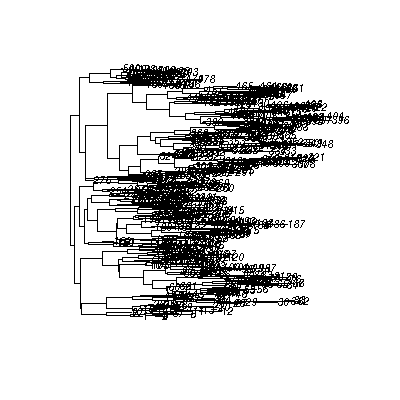

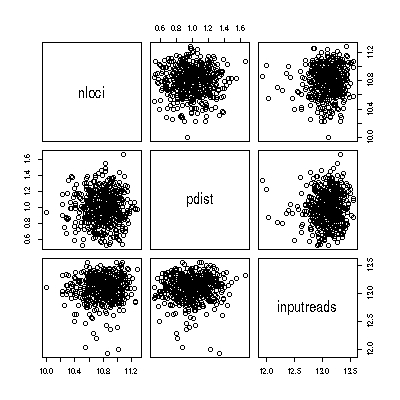

In [5]:
%%R -w 400 -h 400

## matrix size (can it handle big data?)
n = 500

## simulate random data, log-transformed large values
set.seed(54321999)
simdata = data.frame('nloci'=log(rnorm(n, 50000, 10000)), 
                     'pdist'=rnorm(n, 1, 0.2), 
                     'inputreads'=log(abs(rnorm(n, 500000, 100000))))

## simulate a tree of same size
simtree = rtree(n)

## match names of tree to simdata idxs
simtree$tip.label = 1:n

## plot the data
plot(simtree)
plot(simdata)

### Pass objects between R and Python 

In [6]:
## as an example of what we'll be doing with the real data (Python objects)
## let's export them (-o) from R back to Python objects
%R newick <- write.tree(simtree)
%R -o newick
%R -o simdata

## Now we have the tree from R as a string in Python
## and the data frame from R as a pandas data frame in Python
newick = newick.tostring()
simdata = simdata

print simdata.head()

       nloci     pdist  inputreads
1  10.812131  0.854690   13.181553
2  10.809799  1.223541   13.216016
3  10.955710  0.836004   13.191727
4  11.088318  1.047190   13.310152
5  10.630199  1.131851   13.390310


### Model fitting functions
I know this is a bit convoluted, but these are _Python_ functions which call mostly _R_ code to do model fitting. This is because I couldn't find a Python library capable of doing pgls. The funtions take in Python objects, convert them to R objects, compute results, and return values as Python objects. The lines with "%R" execute as R code in IPython. The function rModelFitPhy uses a phylogeny to estimate a covariance matrix and perform model fitting using GLS. 

In [7]:
def rModelFit(pydat, covmat=np.zeros(0), newick=""):
    """ 
    send PyObjects to R and runs pgls using either an 
    input covariance matrix or an input tree. Returns
    the model fit as a dataframe, and the Log likelhiood
    """
    
    ## reconstitute Python data frame as R data frame
    %R -i pydat
    %R data <- data.frame(pydat)
    
    ## which model to use...
    if (not np.any(covmat)) and (not newick):
        %R fit <- gls(nloci ~ inputreads + pdist, data=data)
        
    else:
        ## get covariance (correlation) matrix from tree
        if newick:
            %R -i newick
            %R tre <- read.tree(text=newick)
            %R simmat <- vcv(tre, corr=TRUE)

        ## get covariance matrix from input
        else:
            %R -i covmat
            %R simmat <- cov2cor(covmat)
        
        ## fit the model
        %R tip.heights <- diag(simmat)  
        %R fit <- gls(nloci ~ inputreads + pdist, data=data, \
                      correlation=corSymm(simmat[lower.tri(simmat)], fixed=TRUE), \
                      weights=varFixed(~tip.heights))

    ## return results as data frame
    %R df <- as.data.frame(summary(fit)$tTable)
    %R LL <- fit$logLik
    %R -o df,LL
    
    return df, LL

In [8]:
def rModelFit2(pydat, covmat=np.zeros(0), newick=""):
    """ 
    Send PyObjects to R and run pgls with covariance mat. 
    In contrast to the model above this one only fits the
    model to inputreads, not pdist. We use the likelihood
    fit of this model to estimate estimate lamda by using
    maximum likelihood in the func estimate_lambda. 
    """
    
    ## reconstitute Python data frame as R data frame
    %R -i pydat
    %R data <- data.frame(pydat)
    
    ## which model to use...
    if (not np.any(covmat)) and (not newick):
        %R fit <- gls(nloci ~ inputreads, data=data)
        
    else:
        ## get covariance (correlation) matrix from tree
        if newick:
            %R -i newick
            %R tre <- read.tree(text=newick)
            %R simmat <- vcv(tre, corr=TRUE)

        ## get covariance matrix from input
        else:
            %R -i covmat
            %R simmat <- cov2cor(covmat)
        
        ## fit the model
        %R tip.heights <- diag(simmat)  
        %R fit <- gls(nloci ~ inputreads, data=data, \
                      correlation=corSymm(simmat[lower.tri(simmat)], fixed=TRUE), \
                      weights=varFixed(~tip.heights))

    ## return results as data frame
    %R df <- as.data.frame(summary(fit)$tTable)
    %R LL <- fit$logLik
    %R -o df,LL
    
    return df, LL

### Model fits to random data
Here we did four different model fits to check that our covariacne structure is working correctly. We expect that in all model fits the two variables (inputreads and pdist) will be poor predictors of nloci, since all values were randomly generated. In the first model fit we use no covariance structure and the LL=158. In the second we enforce a covariance structure by getting a VCV from the phylogeny. This gives a much worse fit to the data, as we might expect since the data were not generated with any regard to the phylogeny. The third test checks that when we input a VCV directly we get the same answer as when we put in a tree. We do. This is good since in our quartet analysis below we will be entering just the VCV. Finally, We fit a model that includes a VCV, but where all off-diagonal elements are zero (no covariance). This is equivalent to tranforming the tree by Pagel's lambda = 0. It is encouraging that when we remove the covariance structure in this way we get the same LL=158 as when no covariance structure is present at all. This means that in our real data set we can try to estimate Pagel's lambda for our covariance matrices computed from quartet data and if the covariance structure we create does not fit our data at all then a zero lambda will be estimated and the effect of our covariance structure will be removed. 

In [9]:
print "\nno VCV"
df, LL = rModelFit(simdata)
print df
print "log-likelihood", LL
print "---"*20


print "\nVCV from tree -- entered as tree"
df, LL = rModelFit(simdata, newick=newick)
print df
print "log-likelihood", LL
print "---"*20


print "\nVCV from tree -- entered as VCV"
%R -o simmat
df, LL = rModelFit(simdata, covmat=simmat)  ## <- uses the simmat from the tree
print df
print "log-likelihood", LL
print "---"*20


print "\nVCV from tree -- entered as VCV -- transformed so no VCV structure"
df, LL = rModelFit(simdata, covmat=np.eye(simdata.shape[0]))  ## <- no covar == lambda=0
print df
print "log-likelihood", LL
print "---"*20



no VCV
                Value  Std.Error    t-value       p-value
(Intercept)  9.922016   0.533357  18.602940  5.166341e-59
inputreads   0.068718   0.040775   1.685281  9.256210e-02
pdist       -0.023346   0.046925  -0.497514  6.190467e-01
log-likelihood [ 76.13063426]
------------------------------------------------------------

VCV from tree -- entered as tree
                Value  Std.Error    t-value       p-value
(Intercept)  9.989510   0.530265  18.838714  3.853246e-60
inputreads   0.058181   0.039488   1.473389  1.412792e-01
pdist       -0.004097   0.044443  -0.092186  9.265878e-01
log-likelihood [-43.82137587]
------------------------------------------------------------

VCV from tree -- entered as VCV
                Value  Std.Error    t-value       p-value
(Intercept)  9.989510   0.530265  18.838714  3.853246e-60
inputreads   0.058181   0.039488   1.473389  1.412792e-01
pdist       -0.004097   0.044443  -0.092186  9.265878e-01
log-likelihood [-43.82137587]
-----------------

### A function to optimize lambda
On this simulated data there is little power to detect any covariance structure (lambda fit) in the data because the data is basically just noise. But you'll see below on our simulated data that it fits very well. 

In [10]:
def get_lik_lambda(lam, data, covmat):
    """ a function that can be optimized with ML to find lambda"""
    tmat = covmat*lam
    np.fill_diagonal(tmat, 1.0)
    _, LL = rModelFit2(data, covmat=tmat)
    ## return as the NEGATIVE LL to minimze func
    return -1*LL


def estimate_lambda(data, covmat):
    """ uses fminbound to estimate lambda in [0, 1]"""
    return fminbound(get_lik_lambda, 
                     0, 1, 
                     args=(data, covmat), 
                     xtol=0.001, maxfun=25)

### Fit with lambda
When we fit the model using our estimated lambda, which in this case is 
zero since the data were simulated random (no respect to phylogeny) the 
model fit is the same as above when there is no covariance structure. 
This is good news. We will penalize this model for the extra parameter
using AIC when comparing models. 

In [11]:
print "\nVCV from tree -- entered as VCV -- transformed by estimated lambda"
lam = estimate_lambda(simdata, simmat)
mat = simmat * lam
np.fill_diagonal(mat, 1.0)

df, LL = rModelFit(simdata, covmat=mat)
print df
print "lambda", lam
print "log-likelihood", LL
print "---"*20



VCV from tree -- entered as VCV -- transformed by estimated lambda
                Value  Std.Error    t-value       p-value
(Intercept)  9.922079   0.533376  18.602408  5.196621e-59
inputreads   0.068709   0.040777   1.685011  9.261411e-02
pdist       -0.023326   0.046924  -0.497104  6.193356e-01
lambda 0.00039980409165
log-likelihood [ 76.12267266]
------------------------------------------------------------


## 2. Write functions to get stats info from pyrad outputs

Here we build a large data frame that will store how many loci are shared among all sets of quartets, what the phylogenetic distance spanned by each quartet is (pdist), and how much input data each quartet sample had (inputreads). 

### Parse nloci (shared) from pyrad output 

In [14]:
def getarray(locifile, treefile):
    """ get presence/absence matrix from .loci file 
    (pyrad v3 format) ordered by tips on the tree"""
    
    ## parse the loci file
    infile = open(locifile)
    loci = infile.read().split("\n//")[:-1]
    
    ## order (ladderize) the tree
    tree = ete3.Tree(treefile, format=3)
    tree.ladderize()
    
    ## assign numbers to internal nodes
    nodes = tree.iter_descendants()
    nodenum = 0
    for node in nodes:
        if not node.is_leaf():
            node.name = nodenum
            nodenum += 1
    
    ## get tip names
    names = tree.get_leaf_names()
    
    ## make empty matrix
    lxs = np.zeros((len(names), len(loci)), dtype=np.uint32)
    
    ## fill the matrix
    for loc in xrange(len(loci)):
        for seq in loci[loc].split("\n"):
            if ">" in seq:
                ## drop _0 from sim names if present
                seq = seq.rsplit("_0 ", 1)[0]
                lxs[names.index(seq.split()[0][1:]),loc] += 1
    infile.close()
    
    return lxs, tree

### Get pdist and median inputreads for all(!) quartets

In [6]:
def build_df4_parallel(tree, lxs, s2file, lbview):
    """ 
    Builds a data frame for quartets in parallel. A less generalized 
    form of the 'buildarray' function, and much faster. Returns a 
    data frame with n-shared-loci, median-input-reads, phylo-dist. 
    """
    
    ## get number of taxa
    names = tree.get_leaf_names()
      
    ## read in step2 stats to get inputreads info, correct _0 in names for simdata
    res2 = pd.read_table(s2file, header=0, index_col=0, nrows=len(names))
    res2.index = [i[:-2] if i.endswith("_0") else i for i in res2.index]
    inputdat = res2["passed.total"].reindex(tree.get_leaf_names())
    
    ## create empty array of nquart rows and 7 columns
    nsets = sum(1 for _ in itertools.combinations(xrange(len(names)), 4))
    taxonset = itertools.combinations(xrange(len(names)), 4) 
    arr = np.zeros((nsets, 7), dtype=np.float32)
    
    ## iterate over sampled sets and fill array. 
    asyncs = {}
    sub = 0
    while 1:
        ## grab 100 rows
        hund = np.array(list(itertools.islice(taxonset, 100)))
        
        ## submit to engine
        if np.any(hund):
            asyncs[sub] = lbview.apply(fillrows, *[tree, names, inputdat, hund, lxs])
            sub += 100
        else:
            break

    ## wait for jobs to finish and enter into the results array
    lbview.wait()
    taxonset = itertools.combinations(xrange(len(names)), 4) 
    for idx in xrange(nsets):
        arr[idx, :4] = taxonset.next()
    for idx in xrange(0, sub, 100):
        arr[idx:idx+100, 4:] = asyncs[idx].get()     
        
    ## dress up the array as a dataframe
    columns=["p1", "p2", "p3", "p4", "nloci", "inputreads", "pdist"]
    df = pd.DataFrame(arr, columns=columns)
   
    ## convert quartet indices to ints for prettier printing
    df[["p1", "p2", "p3", "p4"]] = df[["p1", "p2", "p3", "p4"]].astype(int)

    return df

In [15]:
def fillrows(tree, names, inputdat, tsets, lxs):
    """ takes 100 row elements in build df4 """
    
    ## output array 
    arr = np.zeros((tsets.shape[0], 3), dtype=np.float64)
    
    ## get number of loci shared by the set
    for ridx in xrange(tsets.shape[0]):   
        tset = tsets[ridx]
        colsums = lxs[tset, :].sum(axis=0)
        lshare = np.sum(colsums==4)
        
        ## get total tree length separating these four taxa
        t = copy.deepcopy(tree)
        t.prune([names[i] for i in tset], preserve_branch_length=True)
        pdist = sum([i.dist for i in t])
        
        ## get min input reads 
        inputreads = np.median([inputdat[i] for i in tset])
        
        ## fill arr (+1 ensures no log(0) = -inf)
        arr[ridx] = [np.log(lshare+1), np.log(inputreads+1), pdist]
        
    ## return array with 100 values
    return arr

### A simple Class object to store our results in 

In [8]:
## define a class object to store data in
class dataset():
    def __init__(self, name):
        self.name = name
        self.files = fileset()
        
        
## define a class object to store file locations
class fileset(dict):
    """ checks that data handles exist and stores them"""
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        if os.path.exists(value):
            self[name] = value
        else:
            raise AttributeError("bad file name " + value)
        
 

### Calculate a covariance matrix from shared edges among quartets
This is of course different from the VCV we inferred from a tree structure in the example at the beginning of this notebook. Here our data points are not tips of a tree but rather quartets. And we create a covariance matrix that measures the amount of shared edges among sampled quartets. 

In [16]:
def get_path(node, mrca):
    """ get branch length path from tip to chosen node (mrca)"""
    path = set()
    while 1:
        ## check that tips have not coalesced
        if not node == mrca:
            path.add((node, node.up))
            node = node.up
        else:
            return path
        

In [17]:
def calculate_covariance(intree, maxarr=1000):
    """
    get covariance matrix measuring shared branch lengths among quartets, 
    if total number of quartets for a tree is >1000 then randomly sample
    1000 quartets instead. 
    """
    ## tree copy
    tree = copy.deepcopy(intree)
    tree.unroot()
    
    ## create a large empty matrix
    tt = tree.get_leaves()
    nsets = sum(1 for _ in itertools.combinations(range(len(tt)), 4))
    
    ## we're not gonna worry about memory for now, and so make a list
    ## otherwise we would work with iterators
    fullcombs = list(itertools.combinations(range(len(tt)), 4))
                     
    ## either sample all quarets or a random maxarr
    if nsets <= maxarr:
        quarts = np.zeros((nsets, 4), dtype=np.uint16)
        arr = np.zeros((nsets, nsets), dtype=np.float64)
        ridx = np.arange(nsets)
        for i in xrange(nsets):
            quarts[i] = fullcombs[i]
        arrsize = nsets
            
    else:
        quarts = np.zeros((maxarr, 4), dtype=np.uint16)
        arr = np.zeros((maxarr, maxarr), dtype=np.float64)
        ## randomly sample 1000 indices within maxarr
        ridx = np.random.choice(nsets, maxarr)
        for i in xrange(maxarr):
            quarts[i] = fullcombs[ridx[i]]
        arrsize = maxarr
    
    ## iterate over each comb to compare
    for idx in xrange(arrsize):
        
        ## get path to quartet tips
        set1 = [tt[i] for i in quarts[idx]]  
        mrca1 = set1[0].get_common_ancestor(set1)
        edges1 = [get_path(node, mrca1) for node in set1]
                
        for cdx in xrange(idx, arrsize):         
            ## get path to quartet tips
            set2 = [tt[i] for i in quarts[cdx]]  
            mrca2 = set2[0].get_common_ancestor(set2)
            edges2 = [get_path(node, mrca2) for node in set2]
                    
            ## which edges are shared
            a = set([tuple(i) for i in itertools.chain(*edges1)])
            b = set([tuple(i) for i in itertools.chain(*edges2)])
            shared = set.intersection(a, b)
            
            ## save the branch lengths
            sumshare = sum([tree.get_distance(edg[0], edg[1]) for edg in shared])
            arr[idx, cdx] = sumshare
        #print idx,
            
    return arr, ridx
                         

In [18]:
def check_covariance(covar):
    """ tests covariance matrix for positive definite"""

    ## fill the lower triangle of matrix symmetrically
    mat = np.array(covar)
    upidx = np.triu_indices_from(covar)
    mat[(upidx[1], upidx[0])] = covar[upidx]

    ## is the matrix symmetric?
    assert np.allclose(mat, mat.T), "matrix is not symmetric"
    
    ## is it positive definite?
    test = 0
    while 1:
        if not np.all(np.linalg.eigvals(mat) > 0):
            didx = np.diag_indices_from(mat)
            mat[didx] = np.diag(mat) *1.1
            test += 1
        elif test > 20:
            assert np.all(np.linalg.eigvals(mat) > 0), "matrix is not positive definite"
        else:
            break
    assert np.all(np.linalg.eigvals(mat) > 0), "matrix is not positive definite"
            
    return mat        
    

### Function to run model functions together
This allows us to make one call to run jobs in parallel

In [19]:
def fitmodels(tree, df4, nsamples):
    """ 
    Calculates covar, checks matrix, fits models, 
    and return arrays for with and without covar
    """
    ## calculate covariance of (nsamples) random data points
    covar, ridx = calculate_covariance(tree, nsamples)

    ## get symmetric matrix and test for positive definite
    mat = check_covariance(covar)
    
    ## subsample a reasonable number of data points
    subdf4 = df4.loc[ridx, :]
    
    ## estimate lambda to be used in model fits
    ## I'm using R to convert cov2cor
    %R -i mat
    %R mm <-cov2cor(mat)
    %R -o mm
    lam = estimate_lambda(subdf4, mm)

    ## transform corr matrix with lambda
    mat = mm*lam
    np.fill_diagonal(mat, 1.0)    
    
    ## fit models with covar
    ndf, nLL = rModelFit(subdf4)
    wdf, wLL = rModelFit(subdf4, covmat=mat)
    
    ## return two arrays
    return wdf, wLL, nLL, lam #ndf, nLL, wdf, wLL


## 3. Testing on a simulated RAD data set 
In this case we know what the source of missing data is, either mutation (drop) or random (rand). 

For a large tree like this (64) tips this takes quite a while to run (~20 minutes). This is the case even when we only randomly sample 200 quartets out of the possible ~650K. Our solution will be to do many repetitions of subsampling and to parallelize this to get a good estimate quickly. Fortunately our largest empirical data set is about the same size as these simulated data sets, so this gives us a good idea for run times (still pretty long). To repeat this analysis you will have to change the file paths. The files are created in the simulation notebook. 

#### Simulate a new data set variable missing data
I'm simulating a new data set for this since the 'random' missing data sets we made in the sim notebook all have very similar amounts of input data. To get signal from the data we need the input data to vary more significantly among samples. So I simulate some new data here with greater variance. 

More specifically, I will take data from the 'fullcov' data sets which had no missing data
and randomly remove some DIFFERENT proportion of data from each sample. This is different
from our low coverage simulations in which we removed the same proportion of data from 
each sample, but it was randomly missing from different loci. 

#### New balanced tree data set

In [582]:
## make a new directory for the subsampled fastqs
! mkdir -p /home/deren/Documents/RADsims/Tbal_rad_varcov/fastq/

## grab the no-missing fastqs
fastqs = glob.glob("/home/deren/Documents/RADsims/Tbal_rad_covfull/fastq/s*")
for fastq in fastqs:
    ## create a new output file
    _, handle = os.path.split(fastq)
    outfile = gzip.open(
                os.path.join(
                    "/home/deren/Documents/RADsims/Tbal_rad_varcov/fastq",
                    handle), 'w')
    ## grab a random proportion of reads from this data set (0-100%)
    p = np.random.uniform(0.1, 0.9)
    ## iterate over file 4-lines at a time. 
    infile = gzip.open(fastq, 'r')
    qiter = itertools.izip(*[iter(infile)]*4)
    ## sample read with probability p
    kept = 0
    while 1:
        try:
            if np.random.binomial(1, p):
                outfile.write("".join(qiter.next()))
                kept += 1
            else:
                _ = qiter.next()
        except StopIteration:
            break
    print '{} sampled at p={:.2f} kept {} reads'.format(handle, p, kept)
    infile.close()
    outfile.close()
                                             

s109_0_R1.fq.gz sampled at p=0.63 kept 12740 reads
s89_0_R1.fq.gz sampled at p=0.53 kept 10523 reads
s77_0_R1.fq.gz sampled at p=0.47 kept 9367 reads
s71_0_R1.fq.gz sampled at p=0.54 kept 10833 reads
s83_0_R1.fq.gz sampled at p=0.83 kept 16676 reads
s78_0_R1.fq.gz sampled at p=0.75 kept 15139 reads
s116_0_R1.fq.gz sampled at p=0.67 kept 13577 reads
s70_0_R1.fq.gz sampled at p=0.61 kept 12380 reads
s98_0_R1.fq.gz sampled at p=0.12 kept 2451 reads
s120_0_R1.fq.gz sampled at p=0.86 kept 17273 reads
s101_0_R1.fq.gz sampled at p=0.68 kept 13807 reads
s92_0_R1.fq.gz sampled at p=0.24 kept 4640 reads
s108_0_R1.fq.gz sampled at p=0.88 kept 17540 reads
s86_0_R1.fq.gz sampled at p=0.18 kept 3619 reads
s91_0_R1.fq.gz sampled at p=0.66 kept 13325 reads
s125_0_R1.fq.gz sampled at p=0.50 kept 10001 reads
s124_0_R1.fq.gz sampled at p=0.90 kept 17931 reads
s95_0_R1.fq.gz sampled at p=0.43 kept 8791 reads
s105_0_R1.fq.gz sampled at p=0.81 kept 16275 reads
s102_0_R1.fq.gz sampled at p=0.22 kept 4335 rea

In [583]:
%%bash
## assemble the data set in pyrad
rm params.txt 
pyrad -n >> log.txt 2>&1  
sed -i '/## 1. /c\Tbal_rad_varcov       ## 1. working dir ' params.txt
sed -i '/## 2. /c\                      ## 2. data loc ' params.txt
sed -i '/## 3. /c\                      ## 3. Bcode ' params.txt
sed -i '/## 6. /c\TGCAG               ## 6. cutters ' params.txt
sed -i '/## 7. /c\20                  ## 7. Nproc ' params.txt
sed -i '/## 10. /c\.82                ## 10. clust thresh' params.txt
sed -i '/## 11. /c\rad                ## 11. datatype ' params.txt
sed -i '/## 12. /c\2                  ## 12. minCov ' params.txt
sed -i '/## 13. /c\10                 ## 13. maxSH' params.txt
sed -i '/## 14. /c\Tbal               ## 14. outname' params.txt
sed -i '/## 18./c\Tbal_rad_varcov/fastq/*.gz   ## sorted data ' params.txt
sed -i '/## 24./c\99                  ## 24. maxH' params.txt
sed -i '/## 30./c\n,p,s               ## 30. out format' params.txt
pyrad -p params.txt -s 234567 >> log.txt 2>&1  

In [20]:
## load the data files
Tbalvarcov = dataset("Tbalvarcov")
Tbalvarcov.files.loci4 = "/home/deren/Documents/RADsims/Tbal_rad_varcov/outfiles/Tbal.loci"
Tbalvarcov.files.tree = "/home/deren/Documents/RADsims/Tbal.tre"
Tbalvarcov.files.s2 = "/home/deren/Documents/RADsims/Tbal_rad_varcov/stats/s2.rawedit.txt"

#### For the mutation-disruption data set we can re-use the sim data from notebook 1

In [21]:
## balanced tree with only phylo missing data. 
Tbaldrop = dataset("Tbaldrop")
Tbaldrop.files.loci4 = "/home/deren/Documents/RADsims/Tbal_rad_drop/outfiles/Tbal.loci"
Tbaldrop.files.tree = "/home/deren/Documents/RADsims/Tbal.tre"
Tbaldrop.files.s2 = "/home/deren/Documents/RADsims/Tbal_rad_drop/stats/s2.rawedit.txt"

#### New Imbalanced tree data set

In [587]:
## make a new directory for the subsampled fastqs
! mkdir -p /home/deren/Documents/RADsims/Timb_rad_varcov/fastq/

## grab the no-missing fastqs
fastqs = glob.glob("/home/deren/Documents/RADsims/Timb_rad_covfull/fastq/s*")
for fastq in fastqs:
    ## create a new output file
    _, handle = os.path.split(fastq)
    outfile = gzip.open(
                os.path.join(
                    "/home/deren/Documents/RADsims/Timb_rad_varcov/fastq",
                    handle), 'w')
    ## grab a random proportion of reads from this data set (0-100%)
    p = np.random.uniform(0.1, 0.9)
    ## iterate over file 4-lines at a time. 
    infile = gzip.open(fastq, 'r')
    qiter = itertools.izip(*[iter(infile)]*4)
    ## sample read with probability p
    kept = 0
    while 1:
        try:
            if np.random.binomial(1, p):
                outfile.write("".join(qiter.next()))
                kept += 1
            else:
                _ = qiter.next()
        except StopIteration:
            break
    print '{} sampled at p={:.2f} kept {} reads'.format(handle, p, kept)
    infile.close()
    outfile.close()
                                                     

s109_0_R1.fq.gz sampled at p=0.29 kept 5642 reads
s89_0_R1.fq.gz sampled at p=0.72 kept 14463 reads
s77_0_R1.fq.gz sampled at p=0.78 kept 15533 reads
s7_0_R1.fq.gz sampled at p=0.39 kept 7707 reads
s71_0_R1.fq.gz sampled at p=0.68 kept 13722 reads
s1_0_R1.fq.gz sampled at p=0.36 kept 7219 reads
s83_0_R1.fq.gz sampled at p=0.70 kept 13935 reads
s13_0_R1.fq.gz sampled at p=0.90 kept 17865 reads
s25_0_R1.fq.gz sampled at p=0.13 kept 2582 reads
s53_0_R1.fq.gz sampled at p=0.89 kept 17799 reads
s101_0_R1.fq.gz sampled at p=0.44 kept 8844 reads
s91_0_R1.fq.gz sampled at p=0.43 kept 8623 reads
s125_0_R1.fq.gz sampled at p=0.11 kept 2075 reads
s39_0_R1.fq.gz sampled at p=0.31 kept 6213 reads
s41_0_R1.fq.gz sampled at p=0.50 kept 10181 reads
s95_0_R1.fq.gz sampled at p=0.73 kept 14769 reads
s105_0_R1.fq.gz sampled at p=0.76 kept 15280 reads
s9_0_R1.fq.gz sampled at p=0.39 kept 7662 reads
s31_0_R1.fq.gz sampled at p=0.42 kept 8500 reads
s115_0_R1.fq.gz sampled at p=0.74 kept 14700 reads
s27_0_R1

In [588]:
%%bash
## assemble the data set in pyrad
rm params.txt
pyrad -n >> log.txt 2>&1  
sed -i '/## 1. /c\Timb_rad_varcov       ## 1. working dir ' params.txt
sed -i '/## 2. /c\                      ## 2. data loc ' params.txt
sed -i '/## 3. /c\                      ## 3. Bcode ' params.txt
sed -i '/## 6. /c\TGCAG               ## 6. cutters ' params.txt
sed -i '/## 7. /c\20                  ## 7. Nproc ' params.txt
sed -i '/## 10. /c\.82                ## 10. clust thresh' params.txt
sed -i '/## 11. /c\rad                ## 11. datatype ' params.txt
sed -i '/## 12. /c\2                  ## 12. minCov ' params.txt
sed -i '/## 13. /c\10                 ## 13. maxSH' params.txt
sed -i '/## 14. /c\Timb               ## 14. outname' params.txt
sed -i '/## 18./c\Timb_rad_varcov/fastq/*.gz   ## sorted data ' params.txt
sed -i '/## 24./c\99                  ## 24. maxH' params.txt
sed -i '/## 30./c\n,p,s               ## 30. out format' params.txt
pyrad -p params.txt -s 234567 >> log.txt 2>&1  

In [22]:
## imbalanced tree with only phylo missind data. 
Timbvarcov = dataset("Timbvarcov")
Timbvarcov.files.loci4 = "/home/deren/Documents/RADsims/Timb_rad_varcov/outfiles/Timb.loci"
Timbvarcov.files.tree = "/home/deren/Documents/RADsims/Timb.tre"
Timbvarcov.files.s2 = "/home/deren/Documents/RADsims/Timb_rad_varcov/stats/s2.rawedit.txt"

#### Imbalanced tree

In [23]:
## balanced tree with only phylo missind data. 
Timbdrop = dataset("Timbdrop")
Timbdrop.files.loci4 = "/home/deren/Documents/RADsims/Timb_rad_drop/outfiles/Timb.loci"
Timbdrop.files.tree = "/home/deren/Documents/RADsims/Timb.tre"
Timbdrop.files.s2 = "/home/deren/Documents/RADsims/Timb_rad_drop/stats/s2.rawedit.txt"

In [24]:
## list of dsets
dsets = [Tbaldrop, Timbdrop, Tbalvarcov, Timbvarcov]

### Get array of shared loci for each data set

In [25]:
## submit parallel [getarray] jobs
asyncs = {}
for dset in dsets:
    asyncs[dset.name] = lbview.apply(getarray, *[dset.files.loci4, dset.files.tree])
    
## collect results
ipyclient.wait()
for dset in dsets:
    dset.lxs4, dset.tree = asyncs[dset.name].get()
    print dset.name, "\n", dset.lxs4, "\n"

Tbaldrop 
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 0 1 ..., 1 1 1]
 ..., 
 [0 1 1 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]
 [0 1 1 ..., 1 1 1]] 

Timbdrop 
[[1 1 1 ..., 1 0 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]] 

Tbalvarcov 
[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]] 

Timbvarcov 
[[1 1 0 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] 



### Build array of model stats for each data set
This takes a few minutes depending on how many CPUs you're running in parallel. One of the arguments to 'build_df4_parallel' is 'lbview', our load_balanced_view of the parallel processors. 

In [157]:
## submit parallel [buildarray] jobs
for dset in dsets:
     dset.df4 = build_df4_parallel(dset.tree, dset.lxs4, dset.files.s2, lbview)

## peek at one of the data sets
print dsets[3].df4.head()

   p1  p2  p3  p4     nloci  inputreads      pdist
0   0   1   2   3  6.498282    9.054388  23.523808
1   0   1   2   4  6.453625    9.051755  23.523806
2   0   1   2   5  6.643790    9.447268  23.523804
3   0   1   2   6  6.643790    9.520395  23.523802
4   0   1   2   7  6.025866    9.025455  23.523800


### Mean standardize the arrays

In [159]:
for dset in dsets:
    for var in ["nloci", "inputreads", "pdist"]:
        dset.df4[var] = (dset.df4[var] - dset.df4[var].mean()) / dset.df4[var].std()
    
## peek again
print dsets[3].df4.head()

   p1  p2  p3  p4     nloci  inputreads     pdist
0   0   1   2   3  0.759856   -0.598282  2.647565
1   0   1   2   4  0.731862   -0.607247  2.647564
2   0   1   2   5  0.851071    0.739461  2.647563
3   0   1   2   6  0.851071    0.988455  2.647563
4   0   1   2   7  0.463710   -0.696796  2.647563


### To parallelize the next step we need to send our functions to the remote namespace
A much cleaner way to do this would have been to collect all the functions into a Python module and then just import that. Since I'm writing everything out in this notebook to be more didactic, though, we need to perform this step instead. 

In [267]:
ipyclient[:].push(
    dict(
        calculate_covariance=calculate_covariance, 
        check_covariance=check_covariance,
        get_path=get_path,
        rModelFit=rModelFit,
        rModelFit2=rModelFit2,
        estimate_lambda=estimate_lambda,
        get_lik_lambda=get_lik_lambda
        )
    )

<AsyncResult: _push>

### Plot sim data set with a random 1000 quartets sampled

In [161]:
## pass objects into R
rdf0 = dsets[0].df4.loc[np.random.choice(range(630000), 1000), :]
rdf1 = dsets[1].df4.loc[np.random.choice(range(630000), 1000), :]
rdf2 = dsets[2].df4.loc[np.random.choice(range(630000), 1000), :]
rdf3 = dsets[3].df4.loc[np.random.choice(range(630000), 1000), :]

baltre = dsets[0].tree.write()
imbtre = dsets[1].tree.write()
%R -i rdf0,rdf1,rdf2,rdf3,baltre,imbtre

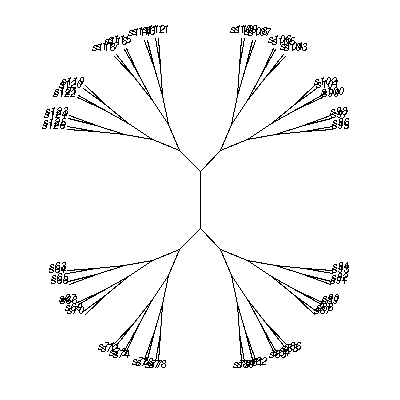

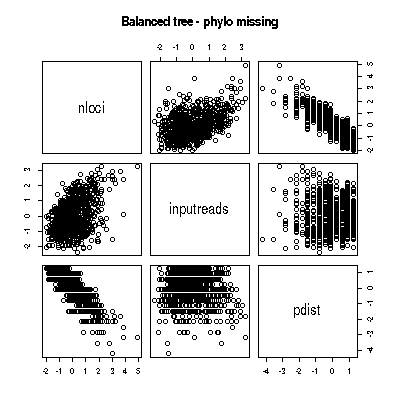

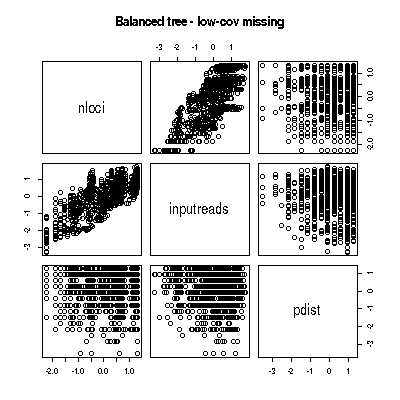

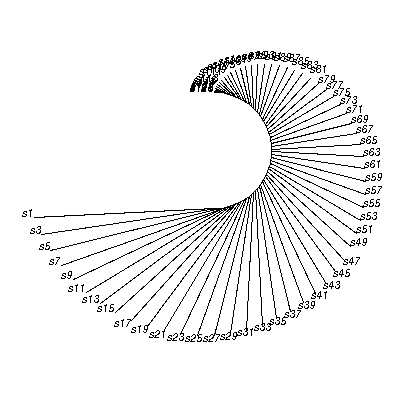

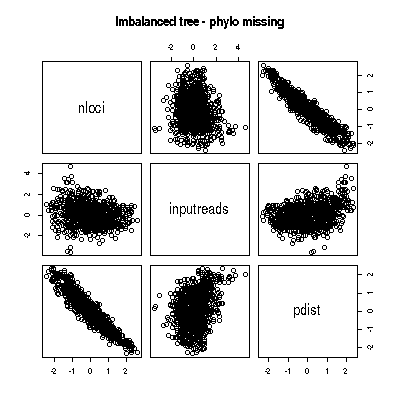

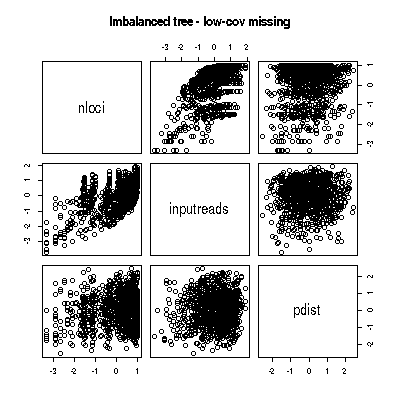

In [177]:
%%R -w 400 -h 400
## make tree and plot data
#pdf("simulation_model_fits.pdf")
tre <- read.tree(text=baltre)
plot(tre, 'u', no.margin=TRUE)
plot(rdf0[,c(5,6,7)], main="Balanced tree - phylo missing")
plot(rdf2[,c(5,6,7)], main="Balanced tree - low-cov missing")

tre <- read.tree(text=imbtre)
plot(tre, 'u', no.margin=TRUE)
plot(rdf1[,c(5,6,7)], main="Imbalanced tree - phylo missing")
plot(rdf3[,c(5,6,7)], main="Imbalanced tree - low-cov missing")
#dev.off()

In [163]:
dset = dsets[0]
print dset.name
fitmodels(dset.tree, dset.df4, nsamples=200)

Tbaldrop


(                Value  Std.Error    t-value       p-value
 (Intercept)  1.316493   0.325814   4.040626  7.638131e-05
 inputreads   0.108283   0.049725   2.177644  3.062066e-02
 pdist       -0.723854   0.035767 -20.238321  5.347518e-50,
 array([-86.29341942]),
 array([-98.23571647]),
 0.99960021071899874)

In [164]:
dset = dsets[1]
print dset.name
fitmodels(dset.tree, dset.df4, nsamples=200)

Timbdrop


(                Value  Std.Error    t-value       p-value
 (Intercept)  0.357928   0.118206   3.027992  2.791243e-03
 inputreads   0.077981   0.029384   2.653831  8.608192e-03
 pdist       -0.775967   0.033450 -23.197634  3.084181e-58,
 array([ 6.62460087]),
 array([-41.82783388]),
 0.99960021071899874)

In [165]:
dset = dsets[2]
print dset.name
fitmodels(dset.tree, dset.df4, nsamples=200)

Tbalvarcov


(                Value  Std.Error   t-value       p-value
 (Intercept) -0.005006   0.378422 -0.013229  9.894588e-01
 inputreads   0.438420   0.050747  8.639289  1.932216e-15
 pdist        0.022305   0.039779  0.560736  5.756146e-01,
 array([-115.62919649]),
 array([-218.92689998]),
 0.99960021071899874)

In [166]:
dset = dsets[3]
print dset.name
fitmodels(dset.tree, dset.df4, nsamples=200)

Timbvarcov


(                Value  Std.Error   t-value   p-value
 (Intercept)  0.292225   0.296549  0.985420  0.325626
 inputreads   0.278069   0.066178  4.201821  0.000040
 pdist        0.015019   0.083815  0.179189  0.857973,
 array([-169.63423911]),
 array([-250.95969846]),
 0.99960021071899874)

In [871]:
def AICc(LL, k, n):
    return (-2*LL) + 2*k + ((2*k * (k+1))/float(n-k-1))

### Run 100 replicate subsample models for each data set

In [167]:
## store results in this array
ntests = 100
nsamples = 200

## for each test
for dset in dsets:
    
    ## create output storage arrays
    dset.tab = np.zeros((ntests, 3, 4), dtype=np.float64)
    dset.LL = np.zeros((2, ntests), dtype=np.float64)
    dset.lam = np.zeros(ntests, dtype=np.float64)
    dset.asyncs = {}

    ## send jobs to get results in parallel
    for tidx in xrange(ntests):
        dset.asyncs[tidx] = lbview.apply(fitmodels, *[dset.tree, dset.df4, nsamples])
    

In [168]:
## check progress on running jobs
ipyclient.wait_interactive()

 400/400 tasks finished after 2532 s
done


In [190]:
## enter results into results array when finished
for dset in dsets:
    ## create empty results arrays
    dset.tab = np.zeros((ntests, 3, 4), dtype=np.float64)
    dset.LL = np.zeros((ntests, 2), dtype=np.float64)
    dset.lam = np.zeros(ntests, dtype=np.float64)
    
    for tidx in range(ntests):
        if dset.asyncs[tidx].ready():
            res = dset.asyncs[tidx].get()
            dset.tab[tidx] = res[0]
            dset.LL[tidx] = res[1], res[2]
            dset.lam[tidx] = res[3]
        else:
            print "job: [{}, {}] is still running".format(dset.name, tidx)

### Simulated data sets results
In all of the data sets the phylo corrected model was a better fit to the data by 30-90 AIC points. When data was missing from low sequence coverage it was best predicted by the inputreads, and when data was missing from mutation-disruption it was best explained by phylo distances. 

In [10]:
def results_table(dset):
    
    tdat = dset.tab.mean(axis=0)
    
    df = pd.DataFrame(
            index=["fit"],
            data=[
             pd.Series([np.mean(dset.LL[:, 0] - dset.LL[:, 1]),
                        dset.lam.mean(),
                        tdat[1, 0],
                        tdat[1, 3],
                        tdat[2, 0], 
                        tdat[2, 3]],
                        index=["deltaAIC", "lambda", 
                               "raw_coeff", "raw_P",
                               "phy_coeff", "phy_P"
                               ]), 
            ])
    return df

In [ ]:
for dset in dsets:
    print dset.name, "---"*23
    print results_table(dset)
    print "---"*27, "\n"

## confidence intervals
The fit for this data set yields a negative AIC both with and without a covariance matrix. This shows that the amount of input data (raw) is a better predictor of shared data bewteen samples than is their phylogenetic distance. See the plot below. 

In [11]:
## get a stats module
import scipy.stats as st


def get_CI(a):
    mean = np.mean(a)
    interval = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    return mean, interval[0], interval[1]


In [211]:
for dset in dsets:
    print dset.name
    print "LL ", get_CI(dset.LL[:,0]-dset.LL[:,1])
    print "lambda", get_CI(dset.lam)
    print "raw_coeff", get_CI(dset.tab[:, 1, 0])
    print "raw_P", get_CI(dset.tab[:, 1, 3])
    print "phy_coeff", get_CI(dset.tab[:, 2, 0])
    print "phy_P", get_CI(dset.tab[:, 2, 3])
    print ""

Tbaldrop
LL  (23.856759534274129, 21.829749489780468, 25.88376957876779)
lambda (0.99960021071899863, 0.99960021071899863, 0.99960021071899863)
raw_coeff (0.13568239558264156, 0.12812141652035028, 0.14324337464493284)
raw_P (0.024666691324290207, 0.014585128766543148, 0.034748253882037269)
phy_coeff (-0.6769798951303041, -0.68335711359863527, -0.67060267666197293)
phy_P (2.5749563846554715e-40, -2.1841376927471948e-40, 7.3340504620581375e-40)

Timbdrop
LL  (65.677319469030465, 63.130619443668124, 68.224019494392806)
lambda (0.99960021071899863, 0.99960021071899863, 0.99960021071899863)
raw_coeff (0.057643349844981484, 0.052702255250656013, 0.062584444439306955)
raw_P (0.078935644079727127, 0.05246785465072315, 0.1054034335087311)
phy_coeff (-0.77709373560218054, -0.78286652717051897, -0.7713209440338421)
phy_P (2.1047686953953927e-59, -4.7643012141171706e-60, 4.6859675122025025e-59)

Tbalvarcov
LL  (78.160889279028424, 76.068056338898998, 80.253722219157851)
lambda (0.99960021071899863

### How to deal with large matrices (absurd run times)
OK, so in our test example it takes about 10 minutes to compute a matrix with only 4000 elements, meaning we can expect that a matrix of several hundred thousand elements will pretty much never finish. One work around for this is to take a sub-sampling approach. The full matrix for 13 taxa is ~700 induced quartets, while the full data set for 65 taxa is ~700K. For the latter we will subsample 100 matrices composed of 1000 random quartets. Then we will compute the covariance matrix of the sampled quartets and fit a regression model. Finally, the results over all 100 subsampled replicates will be reported as a 95% confidence interval. 

### Get all 10 empirical data sets

In [16]:
## data set 1 (Viburnum)
data1 = dataset("data1")
data1.files.loci4 = "/home/deren/Documents/RADmissing/empirical_1/fullrun/outfiles/empirical_1_full_m4.loci"
data1.files.tree = "/home/deren/Documents/RADmissing/empirical_1/fullrun/RAxML_bipartitions.empirical_1_full_m4"
data1.files.s2 = "/home/deren/Documents/RADmissing/empirical_1/fullrun/stats/s2.rawedit.txt"

## data set 2 (Phrynosomatidae)
data2 = dataset("data2")
data2.files.loci4 = "/home/deren/Documents/RADmissing/empirical_2/outfiles/empirical_2_m4.loci"
data2.files.tree = "/home/deren/Documents/RADmissing/empirical_2/RAxML_bipartitions.empirical_2"
data2.files.s2 = "/home/deren/Documents/RADmissing/empirical_2/stats/s2.rawedit.txt"

## data set 3 (Quercus)
data3 = dataset("data3")
data3.files.loci4 = "/home/deren/Documents/RADmissing/empirical_3/outfiles/empirical_3_m4.loci"
data3.files.tree = "/home/deren/Documents/RADmissing/empirical_3/RAxML_bipartitions.empirical_3"
data3.files.s2 = "/home/deren/Documents/RADmissing/empirical_3/stats/s2.rawedit.txt"

## data set 4 (Orestias)
data4 = dataset("data4")
data4.files.loci4 = "/home/deren/Documents/RADmissing/empirical_4/outfiles/empirical_4_m4.loci"
data4.files.tree = "/home/deren/Documents/RADmissing/empirical_4/RAxML_bipartitions.empirical_4"
data4.files.s2 = "/home/deren/Documents/RADmissing/empirical_4/stats/s2.rawedit.txt"

## data set 5 (Heliconius)
data5 = dataset("data5")
data5.files.loci4 = "/home/deren/Documents/RADmissing/empirical_5/outfiles/empirical_5_m4.loci"
data5.files.tree = "/home/deren/Documents/RADmissing/empirical_5/RAxML_bipartitions.empirical_5"
data5.files.s2 = "/home/deren/Documents/RADmissing/empirical_5/stats/s2.rawedit.txt"

## data set 6 (Finches)
data6 = dataset("data6")
data6.files.loci4 = "/home/deren/Documents/RADmissing/empirical_6/outfiles/empirical_6_m4.loci"
data6.files.tree = "/home/deren/Documents/RADmissing/empirical_6/RAxML_bipartitions.empirical_6"
data6.files.s2 = "/home/deren/Documents/RADmissing/empirical_6/stats/s2.rawedit.txt"

## data set 7 (Danio)
data7 = dataset("data7")
data7.files.loci4 = "/home/deren/Documents/RADmissing/empirical_7/outfiles/empirical_7_m4.loci"
data7.files.tree = "/home/deren/Documents/RADmissing/empirical_7/RAxML_bipartitions.empirical_7"
data7.files.s2 = "/home/deren/Documents/RADmissing/empirical_7/stats/s2.rawedit.txt"

## data set 8 (Barnacles)
data8 = dataset("data8")
data8.files.loci4 = "/home/deren/Documents/RADmissing/empirical_8/outfiles/empirical_8_m4.loci"
data8.files.tree = "/home/deren/Documents/RADmissing/empirical_8/RAxML_bipartitions.empirical_8"
data8.files.s2 = "/home/deren/Documents/RADmissing/empirical_8/stats/s2.rawedit.txt"

## data set 9 (Ohomopterus)
data9 = dataset("data9")
data9.files.loci4 = "/home/deren/Documents/RADmissing/empirical_9/outfiles/empirical_9_m4.loci"
data9.files.tree = "/home/deren/Documents/RADmissing/empirical_9/RAxML_bipartitions.empirical_9"
data9.files.s2 = "/home/deren/Documents/RADmissing/empirical_9/stats/s2.rawedit.txt"

## data set 10 (Pedicularis)
data10 = dataset("data10")
data10.files.loci4 = "/home/deren/Documents/RADmissing/empirical_10/outfiles/empirical_10_m4.loci"
data10.files.tree = "/home/deren/Documents/RADmissing/empirical_10/RAxML_bipartitions.empirical_10_m4"
data10.files.s2 = "/home/deren/Documents/RADmissing/empirical_10/stats/s2.rawedit.txt"

## put all in a list
datasets = [data1, data2, data3, data4, data5,
            data6, data7, data8, data9, data10]

### Create large data frames for each data set


In [17]:
## submit parallel [getarray] jobs
asyncs = {}
for dset in datasets:
    asyncs[dset.name] = lbview.apply(getarray, *[dset.files.loci4, dset.files.tree])
    
## collect results
ipyclient.wait()
for dset in datasets:
    dset.lxs4, dset.tree = asyncs[dset.name].get()
    print dset.name, "\n", dset.lxs4, "\n"

data1 
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 1 1 0]
 [0 1 0 ..., 1 0 0]
 ..., 
 [0 1 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 1 0 0]] 

data2 
[[0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 1 0]] 

data3 
[[0 0 1 ..., 1 1 1]
 [1 1 0 ..., 1 1 0]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 0 0 ..., 1 1 1]
 [1 1 1 ..., 0 1 1]
 [1 0 1 ..., 1 1 1]] 

data4 
[[1 1 0 ..., 1 1 0]
 [0 1 0 ..., 1 1 0]
 [0 1 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 1 1 1]
 [1 0 1 ..., 1 1 0]
 [1 0 1 ..., 1 1 0]] 

data5 
[[1 0 0 ..., 0 0 0]
 [1 0 0 ..., 1 0 0]
 [1 0 0 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] 

data6 
[[1 0 1 ..., 1 0 0]
 [1 0 1 ..., 1 0 0]
 [1 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] 

data7 
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 1 ..., 0 0 0]
 [0 0 1 ..., 1 0 1]
 [0 0 1 ..., 1 0 0]] 

data8 
[[1 0 0 ..., 0 0 1]
 [0 0 1 ..., 0

In [18]:
## submit parallel [buildarray] jobs
for dset in datasets:
    dset.df4 = build_df4_parallel(dset.tree, dset.lxs4, dset.files.s2, lbview)

## peek at one of the data sets
print datasets[0].df4.head()

   p1  p2  p3  p4     nloci  inputreads     pdist
0   0   1   2   3  9.480062   14.934133  0.032760
1   0   1   2   4  9.824553   14.934133  0.031800
2   0   1   2   5  9.613269   15.142473  0.046649
3   0   1   2   6  9.850772   15.052855  0.045819
4   0   1   2   7  9.711237   14.934133  0.045416


In [19]:
for dset in datasets:
    for var in ["nloci", "inputreads", "pdist"]:
        dset.df4[var] = (dset.df4[var] - dset.df4[var].mean()) / dset.df4[var].std()
    
## peek again
print datasets[0].df4.head()

   p1  p2  p3  p4     nloci  inputreads     pdist
0   0   1   2   3  1.741054    0.721897 -3.258168
1   0   1   2   4  2.278262    0.721897 -3.306778
2   0   1   2   5  1.948780    1.565089 -2.555040
3   0   1   2   6  2.319149    1.202390 -2.597063
4   0   1   2   7  2.101554    0.721897 -2.617438


In [283]:
## pass objects into R
rdf0 = datasets[0].df4.loc[np.random.choice(range(630000), 1000), :]

rdftre = datasets[0].tree.write()
%R -i rdf0,rdftre

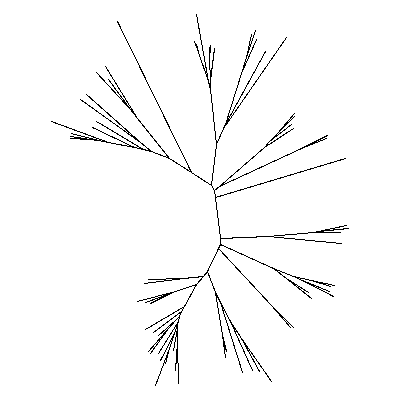

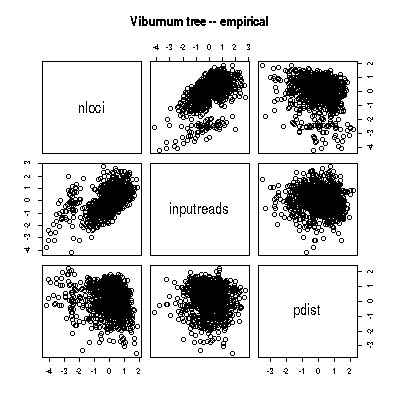

In [284]:
%%R -w 400 -h 400
## make tree and plot data
#pdf("simulation_model_fits.pdf")
tre <- read.tree(text=rdftre)
plot(tre, 'u', no.margin=TRUE, show.tip.label=FALSE)
plot(rdf0[,c(5,6,7)], main="Viburnum tree -- empirical")

In [285]:
## store results in this array
ntests = 100
nsamples = 200

## for each test
for dset in datasets:
    
    ## create output storage arrays
    dset.tab = np.zeros((ntests, 3, 4), dtype=np.float64)
    dset.LL = np.zeros((2, ntests), dtype=np.float64)
    dset.lam = np.zeros(ntests, dtype=np.float64)
    dset.asyncs = {}

    ## send jobs to get results in parallel
    for tidx in xrange(ntests):
        dset.asyncs[tidx] = lbview.apply(fitmodels, *[dset.tree, dset.df4, nsamples])
    

In [286]:
ipyclient.wait_interactive()

1000/1000 tasks finished after 3106 s
done


### Collect the results

In [287]:
## enter results into results array when finished
for dset in datasets:
    ## create empty results arrays
    dset.tab = np.zeros((ntests, 3, 4), dtype=np.float64)
    dset.LL = np.zeros((ntests, 2), dtype=np.float64)
    dset.lam = np.zeros(ntests, dtype=np.float64)
    
    for tidx in range(ntests):
        if dset.asyncs[tidx].ready():
            res = dset.asyncs[tidx].get()
            dset.tab[tidx] = res[0]
            dset.LL[tidx] = res[1], res[2]
            dset.lam[tidx] = res[3]
        else:
            print "job: [{}, {}] is still running".format(dset.name, tidx)

### Print results means

In [288]:
for dset in datasets:
    print dset.name, "---"*23
    print results_table(dset)
    print "---"*27, "\n"

data1 ---------------------------------------------------------------------
       deltaAIC  lambda  raw_coeff         raw_P  phy_coeff     phy_P
fit  130.698514  0.9996   0.308544  2.284103e-08  -0.101696  0.026328
--------------------------------------------------------------------------------- 

data2 ---------------------------------------------------------------------
       deltaAIC  lambda  raw_coeff     raw_P  phy_coeff         phy_P
fit  139.766655  0.9996   0.171828  0.000001  -0.437113  7.029035e-15
--------------------------------------------------------------------------------- 

data3 ---------------------------------------------------------------------
       deltaAIC  lambda  raw_coeff     raw_P  phy_coeff     phy_P
fit  196.594784  0.9996   0.147195  0.006394  -0.126762  0.104418
--------------------------------------------------------------------------------- 

data4 ---------------------------------------------------------------------
       deltaAIC  lambda  raw_coe

### So, for example, why is this one a poor fit for pdist?
There are three clouds of points corresponding to comparisons within and between the major clades. Some with little phylo distance between them have tons of data, while some with tons of data between them have very few data. It comes down to whether those data points include the same few samples or not. When we control for their non-independence, those clouds of points represent much less information, and in essence the pattern disappears. 

In [298]:
## pass objects into R
rdf0 = datasets[5].df4.loc[np.random.choice(range(10000), 1000), :]
rdftre = datasets[5].tree.write()
%R -i rdf0,rdftre

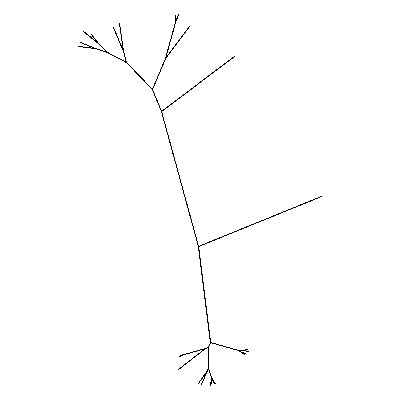

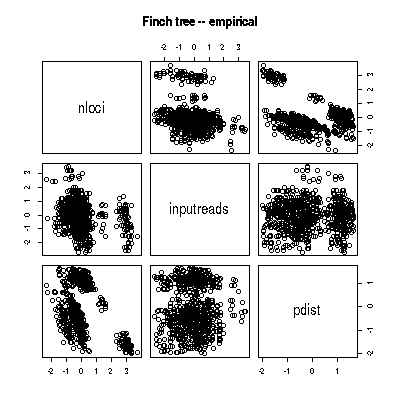

In [299]:
%%R -w 400 -h 400
## make tree and plot data
#pdf("simulation_model_fits.pdf")
tre <- read.tree(text=rdftre)
plot(tre, 'u', no.margin=TRUE, show.tip.label=FALSE)
plot(rdf0[,c(5,6,7)], main="Finch tree -- empirical")

## Confidence intervals 

In [300]:
for dset in datasets:
    print dset.name
    print "LL ", get_CI(dset.LL[:,0]-dset.LL[:,1])
    print "lambda", get_CI(dset.lam)
    print "raw_coeff", get_CI(dset.tab[:, 1, 0])
    print "raw_P", get_CI(dset.tab[:, 1, 3])
    print "phy_coeff", get_CI(dset.tab[:, 2, 0])
    print "phy_P", get_CI(dset.tab[:, 2, 3])
    print ""

data1
LL  (130.69851434371012, 128.12865718594313, 133.26837150147711)
lambda (0.99960021071899863, 0.99960021071899863, 0.99960021071899863)
raw_coeff (0.30854365419893531, 0.30269096411409419, 0.31439634428377644)
raw_P (2.2841026613240539e-08, 5.1787065617999179e-09, 4.050334666468116e-08)
phy_coeff (-0.10169604278335902, -0.10569554280416416, -0.097696542762553878)
phy_P (0.026328111852941694, 0.019620024893717718, 0.033036198812165671)

data2
LL  (139.76665526389243, 137.16253099018172, 142.37077953760314)
lambda (0.99960021071899863, 0.99960021071899863, 0.99960021071899863)
raw_coeff (0.1718278777600889, 0.16635506033100297, 0.17730069518917482)
raw_P (1.0950423602466082e-06, -1.3680492412632838e-07, 2.3268896446195447e-06)
phy_coeff (-0.43711285751896845, -0.44358870600769951, -0.43063700903023738)
phy_P (7.0290350999570793e-15, -6.4202800228952231e-16, 1.4700098202203681e-14)

data3
LL  (196.59478360519438, 194.66975703591095, 198.51981017447781)
lambda (0.99960021071899863, 0

### Make all plots for supp fig 4

In [68]:
## pass objects into R
dset = datasets[0]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [69]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Vib.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Viburnum")
dev.off()

PNG 
  2 


In [72]:
dset = datasets[1]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [73]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Phryn.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Phrynosomatidae")
dev.off()

PNG 
  2 


In [75]:
dset = datasets[2]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [76]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Quer.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Quercus")
dev.off()

PNG 
  2 


In [77]:
dset = datasets[3]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [78]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Orest.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Orestias")
dev.off()

PNG 
  2 


In [79]:
dset = datasets[4]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [80]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Helic.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Heliconius")
dev.off()

PNG 
  2 


In [83]:
dset = datasets[5]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [84]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Finch.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Finches")
dev.off()

PNG 
  2 


In [85]:
dset = datasets[6]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [86]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Danio.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Danio")
dev.off()

PNG 
  2 


In [87]:
dset = datasets[7]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [88]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Barnacles.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Barnacles")
dev.off()

PNG 
  2 


In [89]:
dset = datasets[8]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [90]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Ohomo.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Ohomopterus")
dev.off()

PNG 
  2 


In [91]:
dset = datasets[9]
rdf = dset.df4.loc[np.random.choice(dset.df4.shape[0], 1000), :]
%R -i rdf

In [92]:
%%R -w 400 -h 400
## make tree and plot data
pdf("empscatter_Pedi.pdf", height=5, width=5)
plot(rdf[,c(5,6,7)], main="Pedicularis")
dev.off()

PNG 
  2 
